# Телеком — Поиск клиента с неоптимальными тарифами

**Материалы**

* [Дашборд](https://public.tableau.com/views/nu_pozvoni_telecom/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link) - Количество вызовов и их соотношение по направлению


**Заказчиком** является провайдер виртуальной телефонии «Нупозвони».  
**Клиентами** заказчика являются колл-центры.  

**Цель поиска:** Найти клиентов, которые
- переплачивают на текущих тарифах; 
- сэкономят, если перейдут на более дорогой тариф.

**Описание данных:**  

Датасеты описывают использование услуг провайдера виртуальной телефонии «Нупозвони».   
Его клиенты — колл-центры, которые:
  1. распределяют входящие вызовы на операторов,
  2. совершают исходящие вызовы силами операторов.  

Также операторы могут делать внутренние вызовы — вызовы друг между другом внутри сети виртуальной телефонии.
  
**Датасет telecom_dataset**
Колонки:
* user_id — идентификатор клиента (колл-центра)
* date — дата статистики
* direction — направление вызовов
* internal — маркер внутренних и внешних вызовов
* operator_id — идентификатор оператора
* is_missed_call — маркер пропущенных вызовов
* calls_count — количество звонков
* call_duration — длительность звонка без учёта времени ожидания (0 - пропущенный звонок);
* total_call_duration — длительность звонка с учётом времени ожидания.  

**Датасет telecom_clients**
Колонки:  
* user_id — идентификатор клиента (колл-центра)
* tariff_plan — тарифный план клиента (колл-центра)
* date_start — дата регистрации клиента в сервисе

**Правила формирования тарифов A, B, C** 

* tariff_plan — тарифный план
* cost_month — ежемесячная плата, ₽
* cost_incoming_calls — цена за входящие звонки, ₽
* out_calls_in_tariff — исходящие звонки внутри сети, включенные в тариф, мин
* cost_out_calls_over_limit — цена за исходящие звонки внутри сети, сверх лимита, ₽/мин
* cost_out_calls_except_internal — цена за исходящие звонки, кроме внутренних, ₽/мин
* cost_operator — доплата за каждого оператора, ₽/оператор

In [1]:
import pandas as pd
rates = pd.DataFrame({'tariff_plan' : ['A', 'B', 'C'], 
                      'cost_month' : [4000, 2000, 1000],
                      'cost_incoming_calls' : [0, 0, 0],
                      'out_calls_in_tariff' : [2000, 500, 0],
                      'cost_out_calls_over_limit' : [0.1, 0.15, 0.3],
                      'cost_out_calls_except_internal' : [0.3, 0.5, 0.7], 
                      'cost_operator' : [50, 150, 300]})
display (rates)

tariff_plan  cost_month  cost_incoming_calls  out_calls_in_tariff  \
0           A        4000                    0                 2000   
1           B        2000                    0                  500   
2           C        1000                    0                    0   

   cost_out_calls_over_limit  cost_out_calls_except_internal  cost_operator  
0                       0.10                             0.3             50  
1                       0.15                             0.5            150  
2                       0.30                             0.7            300

## Открытие файлов с данными и изучение общей информации

### Импортирование библиотек

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import numpy as np
from scipy import stats as st
import math

# игнорирование ошибок
import warnings
warnings.filterwarnings("ignore")

### Чтение файлов

In [3]:
telecom = pd.read_csv('/datasets/telecom_dataset.csv')

In [4]:
clients = pd.read_csv('/datasets/telecom_clients.csv')

In [5]:
display (telecom.head())
display (clients.head())

user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4   166377  2019-08-05 00:00:00+03:00       out    False     880022.0   

   is_missed_call  calls_count  call_duration  total_call_duration  
0            True            2              0                    4  
1            True            3              0                    5  
2            True            1              0                    1  
3           False            1             10                   18  
4            True            3              0                   25

user_id tariff_plan  date_start
0   166713           A  2019-08-15
1   166901           A  2019-08-23
2   168527           A  2019-10-29
3   167097           A  2019-09-01
4   168193           A  2019-10-16

## Предобработка данных

In [6]:
#изучим справочную информацию по датасетам
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [7]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


### Изучение пропущенных значений 

In [8]:
display(telecom.isnull().sum(axis=0))

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [9]:
display(clients.isnull().sum(axis=0))

user_id        0
tariff_plan    0
date_start     0
dtype: int64

*Пропуски есть только в таблице telecom, в столбцах operator_id и internal*

In [10]:
print ('Доля пропусков в данных, %:'), 
print (round((telecom.isna().sum())/len(telecom)*100, 2))

Доля пропусков в данных, %:
user_id                 0.00
date                    0.00
direction               0.00
internal                0.22
operator_id            15.16
is_missed_call          0.00
calls_count             0.00
call_duration           0.00
total_call_duration     0.00
dtype: float64


In [11]:
# рассмотрим как делятся данные c пропусками в столбце operator_id на входящие и исходящие звонки
telecom_nan = telecom[telecom['operator_id'].isna()]
telecom_nan['direction'].value_counts()

in     7972
out     200
Name: direction, dtype: int64

In [12]:
# рассмотрим у какого количества колл-центров совсем не указаны операторы
operator = telecom.groupby('user_id')['operator_id'].count().reset_index().sort_values(by='operator_id')

operator[operator['operator_id'] == 0].reset_index()

index  user_id  operator_id
0     177   167631            0
1      23   166584            0
2     295   168490            0
3     289   168446            0
4     283   168340            0
5     281   168329            0
6     217   167939            0
7     300   168578            0
8      21   166554            0
9     196   167768            0
10    137   167265            0
11    108   167114            0
12    241   168024            0
13    189   167721            0
14     99   167077            0
15    226   167981            0
16    236   168013            0

*Данные, где большее количество пропусков в столбце operator_id, являются входящими.*  
*Удаление 15% данных может повлиять на анализ, поэтому пропуски заменим "заглушками".*   
*Необходимо сообщить заказчику, что у семнадцати колл-центрах нет данных о операторах.*

In [13]:
# рассмотрим только данные с пропусками в столбце internal
telecom_nan_internal = telecom[telecom['internal'].isna()]
telecom_nan_internal

user_id                       date direction internal  operator_id  \
1007    166405  2019-09-18 00:00:00+03:00        in      NaN          NaN   
1090    166405  2019-10-01 00:00:00+03:00        in      NaN          NaN   
1864    166406  2019-08-20 00:00:00+03:00        in      NaN          NaN   
1924    166406  2019-09-02 00:00:00+03:00        in      NaN     879898.0   
6210    166541  2019-09-26 00:00:00+03:00        in      NaN     908960.0   
...        ...                        ...       ...      ...          ...   
52462   168361  2019-11-09 00:00:00+03:00        in      NaN          NaN   
52590   168361  2019-11-13 00:00:00+03:00        in      NaN          NaN   
52621   168361  2019-11-14 00:00:00+03:00        in      NaN          NaN   
53717   168579  2019-11-09 00:00:00+03:00        in      NaN          NaN   
53799   168598  2019-11-22 00:00:00+03:00        in      NaN     958394.0   

       is_missed_call  calls_count  call_duration  total_call_duration  
1007             True            1              0                   59  
1090             True            1              0                    1  
1864             True            1              0                   36  
1924            False            1              2                    9  
6210            False            1            393                  423  
...               ...          ...            ...                  ...  
52462            True            6              0                   14  
52590            True            2              0                    6  
52621            True            1              0                    2  
53717            True            1              0                   18  
53799           False            1             11                   17  

[117 rows x 9 columns]

In [14]:
display (telecom_nan_internal.isnull().sum(axis=0))

user_id                  0
date                     0
direction                0
internal               117
operator_id             57
is_missed_call           0
calls_count              0
call_duration            0
total_call_duration      0
dtype: int64

*Пропуски в столбце internal незначительны, меньше 1%.*  
*Реальными данными заполнить эти пропуски не возможно, так как  не определить маркер вызова.*  
*На данном этапе предлагаю, пропуски также заменить "заглушками" и продолжать предобработку данных.*

In [15]:
#заменим пропуски заглушкой
telecom['internal'] = telecom['internal'].fillna(0)
telecom['operator_id'] = telecom['operator_id'].fillna(0)
display (telecom.isnull().sum(axis=0))

user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
dtype: int64

### Изучение дубликатов

In [16]:
print ('В датасете telecom', telecom.duplicated().sum(), 'явных дубликатов')
print ('В датасете clients', clients.duplicated().sum(), 'явных дубликатов')

В датасете telecom 4900 явных дубликатов
В датасете clients 0 явных дубликатов


In [17]:
# удалим явные дубликаты
telecom = telecom.drop_duplicates().reset_index(drop=True) 
print ('Количество дубликатов после удаления:', telecom.duplicated().sum())

Количество дубликатов после удаления: 0


In [18]:
print ('Количество дубликатов по столбцам user_id и tariff_plan в датасете clients:', \
       clients.duplicated(subset=['user_id', 'tariff_plan']).sum())

Количество дубликатов по столбцам user_id и tariff_plan в датасете clients: 0


### Изучение уникальных значений столбцов

In [19]:
print ('Уникальные значения столбца direction:', telecom['direction'].unique())
print ('Уникальные значения столбца internal:', telecom['internal'].unique())
print ('Уникальные значения столбца is_missed_call:', telecom['is_missed_call'].unique())
print ('Уникальные значения столбца tariff_plan:', clients['tariff_plan'].unique())

Уникальные значения столбца direction: ['in' 'out']
Уникальные значения столбца internal: [False True]
Уникальные значения столбца is_missed_call: [ True False]
Уникальные значения столбца tariff_plan: ['A' 'C' 'B']


*На этом этапе можно увидеть, что уникальные значения столбца internal только False и True, это показывает, что данные с пропусками замененными заглушками были удалены на этапе удаления дубликатов.*

### Изучение типов данных

In [20]:
# рассмотрим для каких столбцов датасета telecom необходимо изменить тип данных
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49002 entries, 0 to 49001
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              49002 non-null  int64  
 1   date                 49002 non-null  object 
 2   direction            49002 non-null  object 
 3   internal             49002 non-null  object 
 4   operator_id          49002 non-null  float64
 5   is_missed_call       49002 non-null  bool   
 6   calls_count          49002 non-null  int64  
 7   call_duration        49002 non-null  int64  
 8   total_call_duration  49002 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.0+ MB


In [21]:
# изменим тип данных столбца date на дату
telecom['date'] = pd.to_datetime(telecom['date']).dt.date.astype('datetime64')

In [22]:
# изменим тип данных столбца operator_id на целочисленный
telecom['operator_id'] = telecom['operator_id'].astype('int')

In [23]:
# рассмотрим для каких столбцов датасета clients необходимо изменить тип данных
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [24]:
# изменим тип данных столбца date_start на дату
clients['date_start'] = pd.to_datetime(clients['date_start']) 

### Добавление необходимых столбцов

Для удобства добавим столбец с номером месяца

In [25]:
# добавление столбца с месяцем
telecom['month'] = telecom['date'].dt.month
telecom.head(2)

user_id       date direction internal  operator_id  is_missed_call  \
0   166377 2019-08-04        in    False            0            True   
1   166377 2019-08-05       out     True       880022            True   

   calls_count  call_duration  total_call_duration  month  
0            2              0                    4      8  
1            3              0                    5      8

**Вывод по этапу Предобработка данных:**
- Пропуски были обнаружены в датасете telecom, в столбцах operator_id и internal, пропуски заменены заглушками 
- В датасете telecom удалено 4900 явных дубликатов
- Изменили типы данных столбцов date, operator_id и date_start
- Добавили столбец с номером месяца 


## Проведение исследовательского анализа данных 

In [26]:
# объединим два датасета в один 
telecom_clients = telecom.merge(clients, on='user_id', how='left')
display (telecom_clients.info())
display (telecom_clients.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49002 entries, 0 to 49001
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49002 non-null  int64         
 1   date                 49002 non-null  datetime64[ns]
 2   direction            49002 non-null  object        
 3   internal             49002 non-null  object        
 4   operator_id          49002 non-null  int32         
 5   is_missed_call       49002 non-null  bool          
 6   calls_count          49002 non-null  int64         
 7   call_duration        49002 non-null  int64         
 8   total_call_duration  49002 non-null  int64         
 9   month                49002 non-null  int64         
 10  tariff_plan          49002 non-null  object        
 11  date_start           49002 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](2), int32(1), int64(5), object(3)
memory usage: 4.3+ MB


None

user_id       date direction internal  operator_id  is_missed_call  \
0   166377 2019-08-04        in    False            0            True   
1   166377 2019-08-05       out     True       880022            True   
2   166377 2019-08-05       out     True       880020            True   
3   166377 2019-08-05       out     True       880020           False   
4   166377 2019-08-05       out    False       880022            True   

   calls_count  call_duration  total_call_duration  month tariff_plan  \
0            2              0                    4      8           B   
1            3              0                    5      8           B   
2            1              0                    1      8           B   
3            1             10                   18      8           B   
4            3              0                   25      8           B   

  date_start  
0 2019-08-01  
1 2019-08-01  
2 2019-08-01  
3 2019-08-01  
4 2019-08-01

### Изучение общих данных

In [27]:
print ('Количество пользователей:', len(telecom_clients['user_id'].unique()))
print ('Первая дата:', telecom_clients['date'].min())
print ('Последняя дата:', telecom_clients['date'].max())
print ('Количество операторов:', len(telecom_clients['operator_id'].unique()))
print ('Количество звонков:', telecom_clients['calls_count'].sum())
print ('Длительность всех звонков без учета времени ожидания:', telecom_clients['call_duration'].sum())
print ('Длительность всех звонков с учетом времени ожидания:', telecom_clients['total_call_duration'].sum())

Количество пользователей: 307
Первая дата: 2019-08-02 00:00:00
Последняя дата: 2019-11-28 00:00:00
Количество операторов: 1093
Количество звонков: 806709
Длительность всех звонков без учета времени ожидания: 42449555
Длительность всех звонков с учетом времени ожидания: 56673665


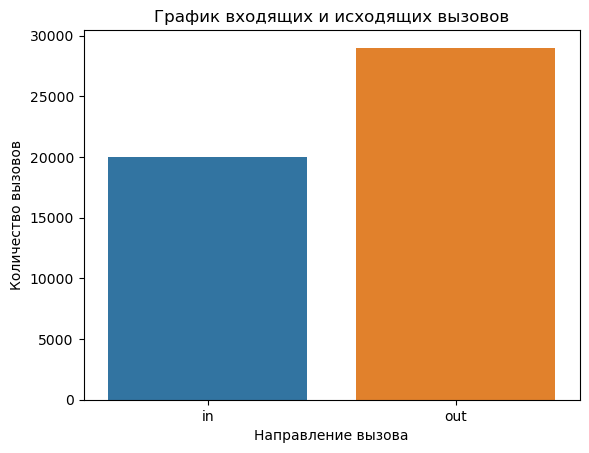

In [28]:
sns.countplot(data = telecom_clients, x='direction')
plt.title('График входящих и исходящих вызовов')
plt.xlabel('Направление вызова')
plt.ylabel('Количество вызовов')
plt.show()

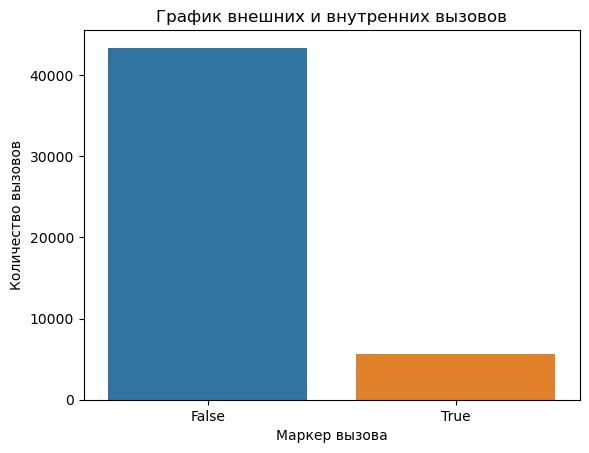

In [29]:
sns.countplot(data = telecom_clients, x='internal')
plt.title('График внешних и внутренних вызовов')
plt.xlabel('Маркер вызова')
plt.ylabel('Количество вызовов')
plt.show()

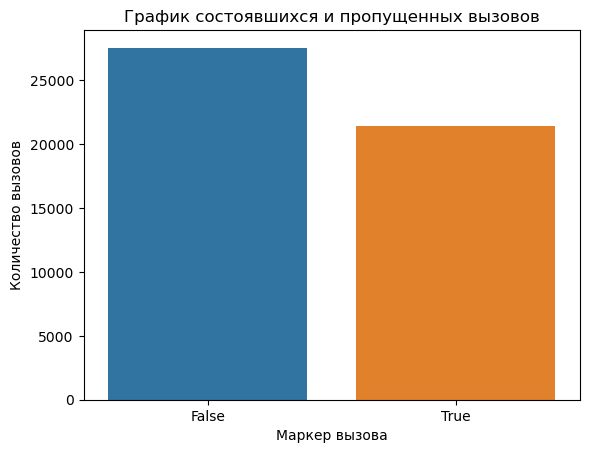

In [30]:
sns.countplot(data = telecom_clients, x='is_missed_call')
plt.title('График состоявшихся и пропущенных вызовов')
plt.xlabel('Маркер вызова')
plt.ylabel('Количество вызовов')
plt.show()

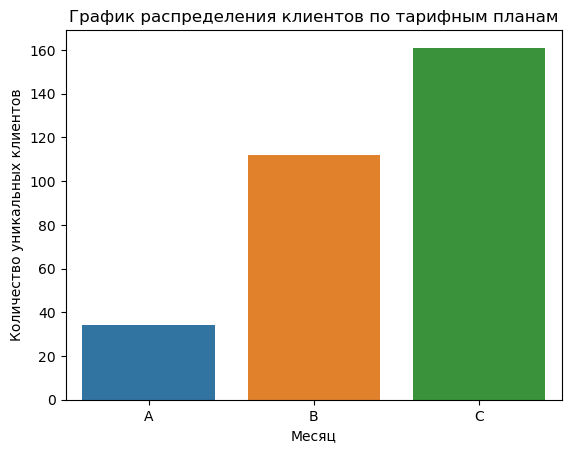

In [31]:
sns.barplot(data = telecom_clients.groupby(['tariff_plan'], as_index=False).agg({'user_id':'nunique'}), \
            x='tariff_plan', y='user_id')
plt.title('График распределения клиентов по тарифным планам')
plt.xlabel('Месяц')
plt.ylabel('Количество уникальных клиентов')
plt.show()

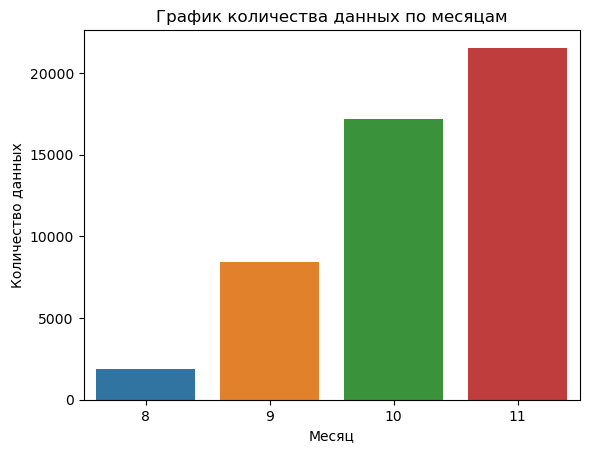

In [32]:
sns.countplot(data = telecom_clients, x='month')
plt.title('График количества данных по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество данных')
plt.show()

#### Изучение выбросов и аномалий, принятие решений

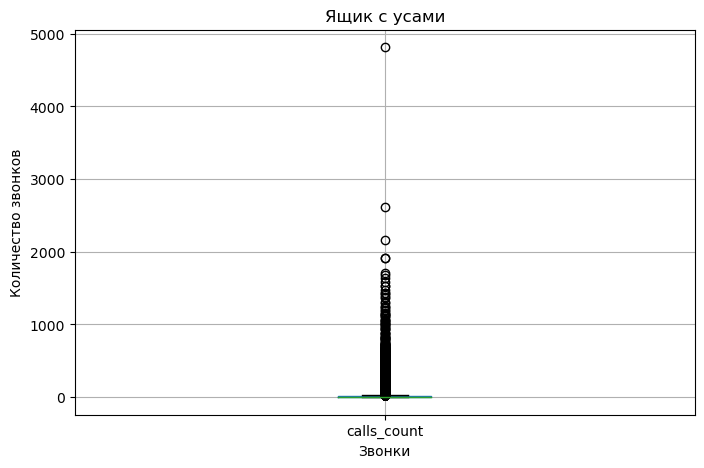

In [33]:
# рассмотрим график "ящик с усами" для столбца calls_count
plt.figure(figsize=(8,5))
telecom_clients[['calls_count']].boxplot()
plt.title('Ящик с усами')
plt.xlabel('Звонки')
plt.ylabel('Количество звонков')
plt.show()

In [34]:
# рассмотрим статистические данные столбца calls_count
telecom_clients['calls_count'].describe()

count    49002.000000
mean        16.462777
std         63.604098
min          1.000000
25%          1.000000
50%          4.000000
75%         12.000000
max       4817.000000
Name: calls_count, dtype: float64

*Количество звонков в день на одного оператора до 5 тысяч.*  
*Для наглядности ограничим график по оси y.*

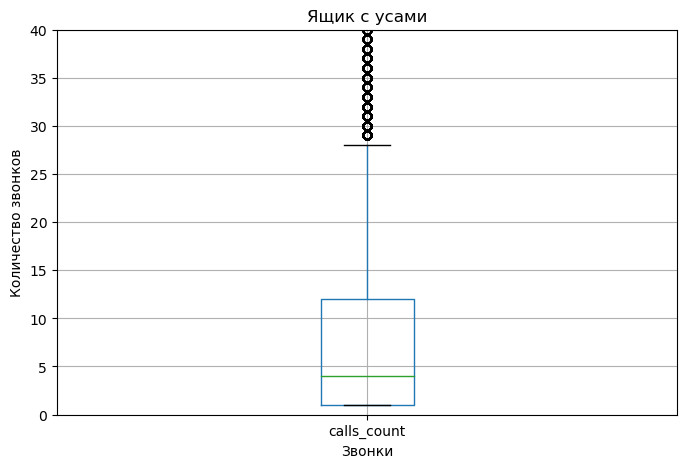

In [35]:
plt.figure(figsize=(8,5))
telecom_clients[['calls_count']].boxplot()
plt.ylim(0, 40)
plt.title('Ящик с усами')
plt.xlabel('Звонки')
plt.ylabel('Количество звонков')
plt.show()

In [36]:
# рассмотрим 90, 95 и 99 перцентили данных
print (np.percentile(telecom_clients['calls_count'], [90, 95, 99]))

[ 35.  62. 165.]


*10 % операторов обрабатывает больше 35 звонков.*   
*5 % операторов обрабатывает больше 62 звонков.*  
*1 % операторов обрабатывает больше 165 звонков.*

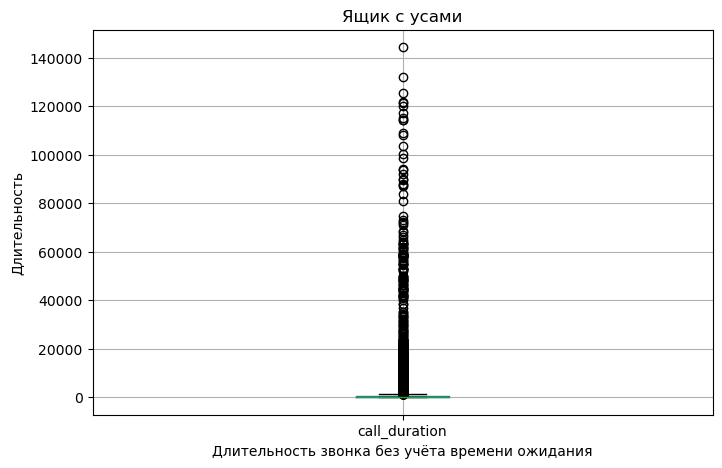

In [37]:
# рассмотрим график "ящик с усами" для столбца call_duration
plt.figure(figsize=(8,5))
telecom_clients[['call_duration']].boxplot()
plt.title('Ящик с усами')
plt.xlabel('Длительность звонка без учёта времени ожидания')
plt.ylabel('Длительность')
plt.show()

In [38]:
display (telecom_clients['call_duration'].describe())

count     49002.000000
mean        866.282091
std        3775.503352
min           0.000000
25%           0.000000
50%          37.000000
75%         570.000000
max      144395.000000
Name: call_duration, dtype: float64

*Длительность звонков в день на одного оператора доходит до 144 тысяч, что является аномально большой цифрой.*  
*Для наглядности ограничим график по оси y.*

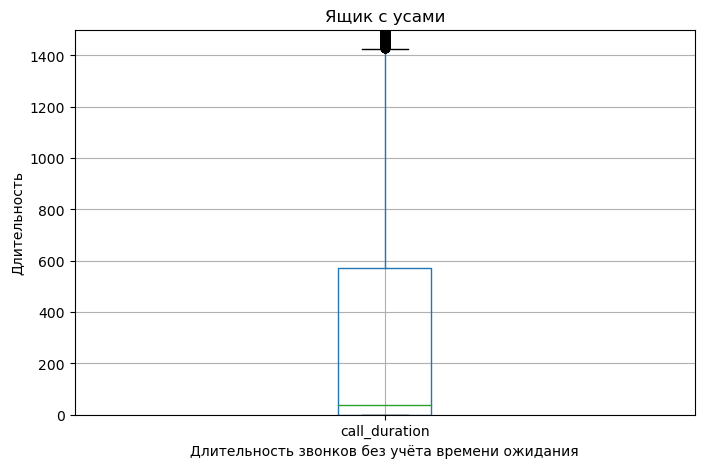

In [39]:
plt.figure(figsize=(8,5))
telecom_clients[['call_duration']].boxplot()
plt.ylim(0, 1500)
plt.title('Ящик с усами')
plt.xlabel('Длительность звонков без учёта времени ожидания')
plt.ylabel('Длительность')
plt.show()

In [40]:
# рассмотрим 90, 95 и 99 перцентили данных
print (np.percentile(telecom_clients['call_duration'], [90, 95, 99]))

[ 2092.    3725.95 10314.91]


*Медианная длительность звонков без учёта времени ожидания 37 единиц.*  
*10 % звонков, без учёта времени ожидания, длительностью больше 2092 единиц.*  
*5 % звонков, без учёта времени ожидания, длительностью больше 3725.9 единиц.*   
*1 % звонков, без учёта времени ожидания, длительностью больше 10314.9 единиц.*   

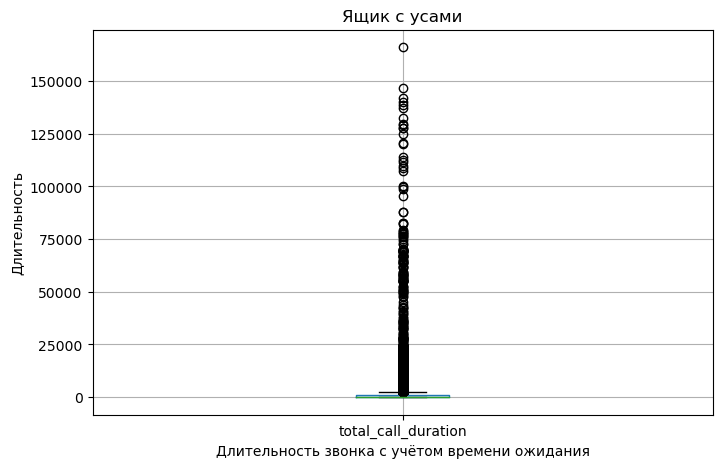

In [41]:
# рассмотрим график "ящик с усами" для столбца total_call_duration
plt.figure(figsize=(8,5))
telecom_clients[['total_call_duration']].boxplot()
plt.title('Ящик с усами')
plt.xlabel('Длительность звонка с учётом времени ожидания')
plt.ylabel('Длительность')
plt.show()

In [42]:
display (telecom_clients['total_call_duration'].describe())

count     49002.000000
mean       1156.558202
std        4451.473661
min           0.000000
25%          46.000000
50%         208.000000
75%         901.000000
max      166155.000000
Name: total_call_duration, dtype: float64

*Сразу видны аномальные значения, но для наглядности ограничим график по оси y.*

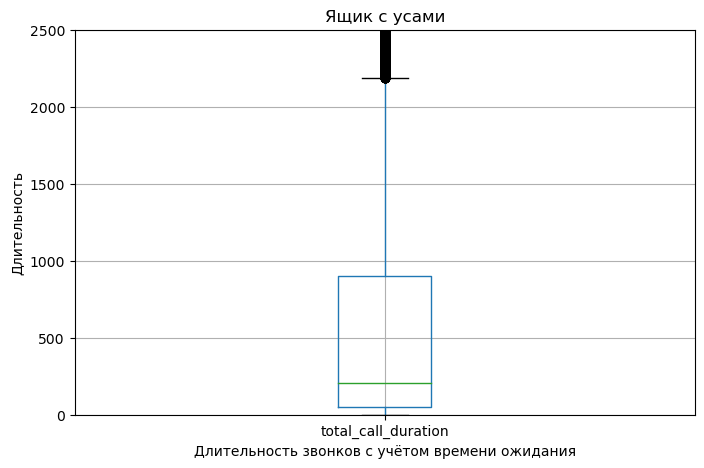

In [43]:
#рассмотрим график "ящик с усами" для столбца total_call_duration
plt.figure(figsize=(8,5))
plt.ylim(0,2500)
telecom_clients[['total_call_duration']].boxplot()
plt.title('Ящик с усами')
plt.xlabel('Длительность звонков с учётом времени ожидания')
plt.ylabel('Длительность')
plt.show()

In [44]:
display (telecom_clients['total_call_duration'].describe())

count     49002.000000
mean       1156.558202
std        4451.473661
min           0.000000
25%          46.000000
50%         208.000000
75%         901.000000
max      166155.000000
Name: total_call_duration, dtype: float64

In [45]:
# рассмотрим 90, 95 и 99 перцентили данных
print (np.percentile(telecom_clients['total_call_duration'], [90, 95, 99]))

[ 2610.8  4531.  12956. ]


*Медианная длительность звонков c учётом времени ожидания 208 единиц.*  
*10 % звонков, c учётом времени ожидания, длительностью больше 2610.8 единиц.*  
*5 % звонков, c учётом времени ожидания, длительностью больше 4531 единиц.*   
*1 % звонков, c учётом времени ожидания, длительностью больше 12956 единиц.*   

**Определим единицы измерения времени для столбцов: call_duration, total_call_duration**

*Выделим состоявшиеся звонки и определим сколько за день разговаривает оператор*

In [46]:
call =  telecom_clients [telecom_clients['call_duration'] > 0].groupby(['date', 'operator_id'], as_index=False)\
                                                              .agg({'calls_count':'sum', 
                                                                    'call_duration':'sum' ,
                                                                    'total_call_duration':'sum'})
call.head(2)

date  operator_id  calls_count  call_duration  total_call_duration
0 2019-08-02       879896            5             31                  146
1 2019-08-02       879898            1            132                  145

*Посчитаем медиану столбца длительности звонков с учетом времени ожидания за день*

In [47]:
median = call['total_call_duration'].median()
median

893.5

*Разделим полученное медианное значение на 60, для перевода в часы (если единицы измерения минуты) и в минуты (если единицы измерения секунды)*

In [48]:
print (round(median/60), 'часов')

15 часов


In [49]:
print (round(median/60), 'минут')

15 минут


In [50]:
call['total_call_duration'].mean()

2593.9270932319714

*Если единицы измерения **минуты**, то оператор на разговоры тратит 13 часов в день, такое количество разговоров кажется не реалистичным для одного рабочего дня.*

*Если единицы измерения **секунды**, то оператор тратит на разговоры 13 минут в день.*

*Более логичным будет принять за единицу измерения длительности звонков - **секунды**.*

In [51]:
# рассмотрим какая длительность звонков у каждого оператора за каждый день
anomall_calls = telecom_clients.groupby(['user_id', 'date', 'operator_id'], as_index=False)\
                               .agg({'total_call_duration':'sum'})\
                               .sort_values('total_call_duration', ascending=False)
# пересчитаем столбец total_call_duration в часах
anomall_calls['total_call_duration'] = anomall_calls['total_call_duration']/3600 
display (anomall_calls)

user_id       date  operator_id  total_call_duration
3272    166582 2019-09-25       885876            52.774722
3275    166582 2019-09-26       885876            47.823611
3224    166582 2019-09-09       885876            44.673889
3251    166582 2019-09-18       885876            44.216111
3293    166582 2019-10-02       885876            43.167222
...        ...        ...          ...                  ...
14472   167199 2019-09-29            0             0.000000
8138    166901 2019-11-26            0             0.000000
14477   167199 2019-10-02            0             0.000000
16502   167471 2019-10-30       944646             0.000000
8982    166971 2019-11-07            0             0.000000

[26646 rows x 4 columns]

*Для наглядности, построим гистограмму на которой отобразим длительность звонков каждого оператора за день в часах.*

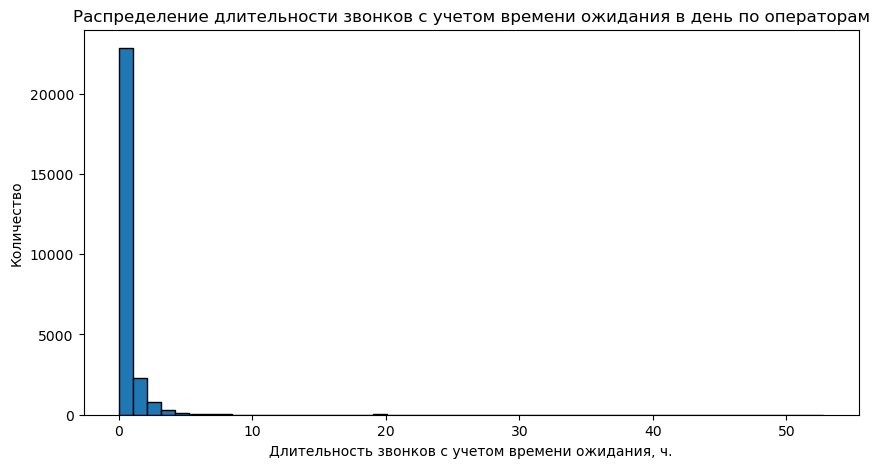

In [52]:
plt.figure(figsize=(10, 5))
plt.hist(anomall_calls['total_call_duration'], bins=50, edgecolor='k')
plt.xlabel('Длительность звонков с учетом времени ожидания, ч.')
plt.ylabel('Количество')
plt.title('Распределение длительности звонков с учетом времени ожидания в день по операторам')
plt.show()

*Представлены абсолютно не реалестичные цифры - 50 часов за день под одним id оператора.*     
*Возможно, что говорит о недобросовестности колл-центра и под одним номером оператора работает несколько сотрудников, чтобы сэкономить на доплатах за каждого оператора.*

In [53]:
#примем за рабочий день / смену оператора - 12 часов
anomall_calls = anomall_calls[anomall_calls['total_call_duration'] > 12]

Выведем список колл-центров, которые необходимо проверить

In [54]:
print (anomall_calls['user_id'].unique())

[166582 168252 167827 168361 167285]


*__Для дальнейшего анализа, принято решение исключить не реалистичные данные из датасета, где total_call_duration > 4531__*

Запишем очищенные данные (без выбросов) в переменную telecom_data

In [55]:
telecom_data = telecom_clients[telecom_clients['total_call_duration'] < 4531]
display (telecom_data)

user_id       date direction internal  operator_id  is_missed_call  \
0       166377 2019-08-04        in    False            0            True   
1       166377 2019-08-05       out     True       880022            True   
2       166377 2019-08-05       out     True       880020            True   
3       166377 2019-08-05       out     True       880020           False   
4       166377 2019-08-05       out    False       880022            True   
...        ...        ...       ...      ...          ...             ...   
48997   168606 2019-11-10       out     True       957922           False   
48998   168606 2019-11-10       out     True       957922            True   
48999   168606 2019-11-11       out     True       957922           False   
49000   168606 2019-11-15       out     True       957922           False   
49001   168606 2019-11-19        in    False            0            True   

       calls_count  call_duration  total_call_duration  month tariff_plan  \
0                2              0                    4      8           B   
1                3              0                    5      8           B   
2                1              0                    1      8           B   
3                1             10                   18      8           B   
4                3              0                   25      8           B   
...            ...            ...                  ...    ...         ...   
48997            1              0                   25     11           C   
48998            1              0                   38     11           C   
48999            2            479                  501     11           C   
49000            4           3130                 3190     11           C   
49001            2              0                   64     11           C   

      date_start  
0     2019-08-01  
1     2019-08-01  
2     2019-08-01  
3     2019-08-01  
4     2019-08-01  
...          ...  
48997 2019-10-31  
48998 2019-10-31  
48999 2019-10-31  
49000 2019-10-31  
49001 2019-10-31  

[46550 rows x 12 columns]

In [56]:
print ('Из датасета исключено','{:.1%}'.format((len(telecom_clients)-len(telecom_data))/len(telecom_clients)), 'данных')

Из датасета исключено 5.0% данных


In [57]:
print ('После обработки датасета, осталось:', telecom_data['user_id'].nunique(), 'клиента')

После обработки датасета, осталось: 307 клиента


#### Выявление активных клиентов, которых будем анализировать

In [58]:
print ('В датасете с договорами на подключение представлено', clients['user_id'].nunique(), 'уникальных клиента')

В датасете с договорами на подключение представлено 732 уникальных клиента


In [59]:
print ('В датасете со звонками, на период сбора данных,', telecom_data['user_id'].nunique(), 'уникальных клиента')

В датасете со звонками, на период сбора данных, 307 уникальных клиента


*В момент объединения двух датасетов отфильтровались не активные клиенты.*  
*В итоговый датасет попало только 307 активных клиентов.*   

####  Определение периода, за который будет проводиться анализ

In [60]:
print ('Первый день сбора данных:', telecom_data['date'].min())
print ('Последний день сбора данных:', telecom_data['date'].max())

Первый день сбора данных: 2019-08-02 00:00:00
Последний день сбора данных: 2019-11-28 00:00:00


*Начало сбора данных пришлось на 2 августа.*   
*Окончание сбора данных пришлось на 28 ноября.*  
*Получается в данные не вошли 1 августа и 29-30 ноября.*

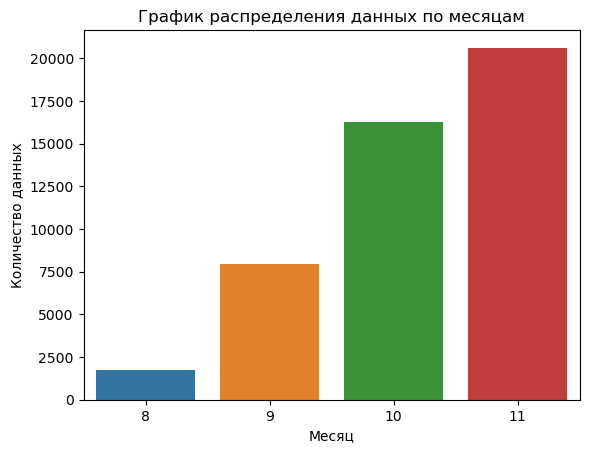

In [61]:
# рассмотрим как распределились данные по месяцам
sns.countplot(data = telecom_data, x='month')

plt.title('График распределения данных по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество данных')
plt.show()

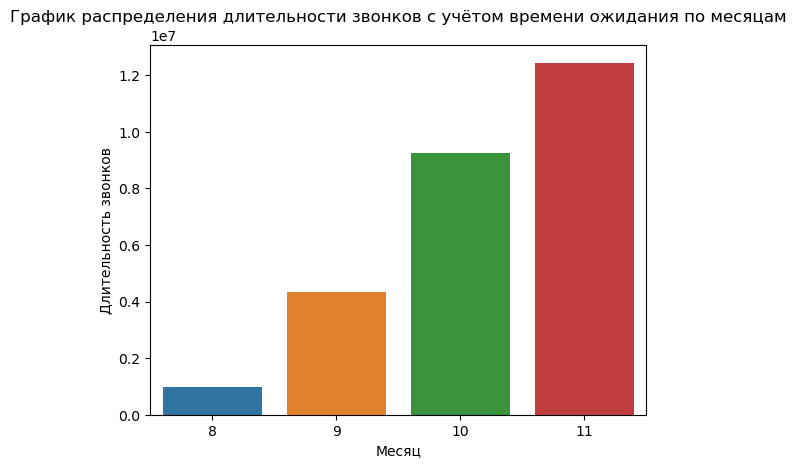

In [62]:
# построим график распределения длительности звонков с учётом времени ожидания по месяцам
sns.barplot(data = telecom_data.groupby(['month'], as_index=False).agg({'total_call_duration':'sum'}), \
            x='month', \
            y='total_call_duration')

plt.title('График распределения длительности звонков с учётом времени ожидания по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Длительность звонков')
plt.show()

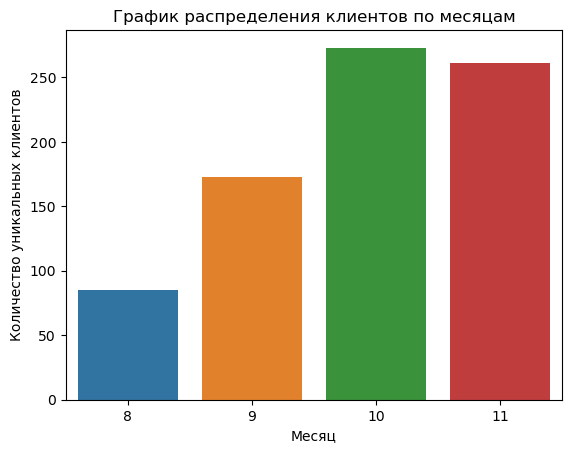

In [63]:
# посмотрим распределение клиентов по месяцам
sns.barplot(data = telecom_data.groupby(['month'], as_index=False).agg({'user_id':'nunique'}), \
            x='month', y='user_id')

plt.title('График распределения клиентов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество уникальных клиентов')
plt.show()

*В августе наименьшая общая длительность звонков и меньше всего уникальных клиентов.*

*__Возможно данные за август могут быть не полными, поэтому для дальнейшего анализа выберем период сентябрь - ноябрь__*

In [64]:
# исключаем из датасета данные за август
telecom_data = telecom_data[telecom_data['date'] >= '2019-09-01']

In [65]:
print ('Количество уникальных клиентов за период сентябрь-ноябрь:', telecom_data['user_id'].nunique())

Количество уникальных клиентов за период сентябрь-ноябрь: 303


Рассмотрим как активные клиенты распределились по тарифам и месяцам после выбора периода и удаления выбросов

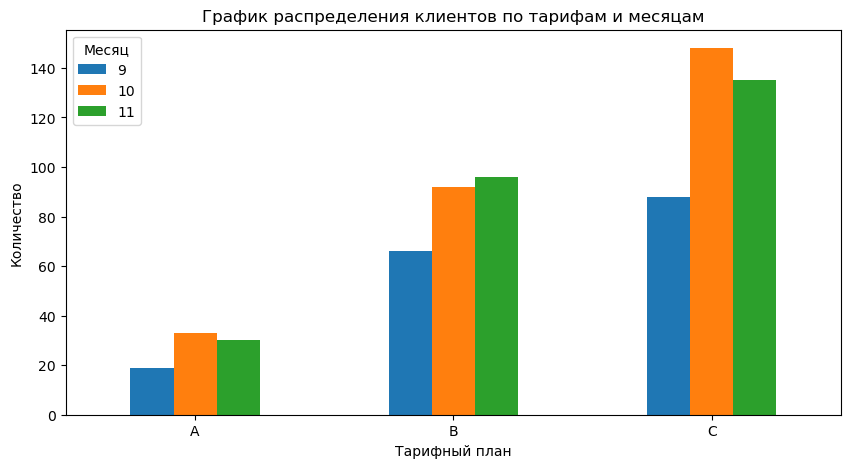

In [66]:
telecom_data.pivot_table(index='tariff_plan', columns ='month', values='user_id', aggfunc='nunique')\
             .plot(kind='bar', figsize=(10,5))

plt.title('График распределения клиентов по тарифам и месяцам')
plt.legend(title='Месяц')
plt.xlabel('Тарифный план')
plt.ylabel('Количество')
plt.xticks(rotation=360)
plt.show()

####  Изучение расходов клиентов на каждом из тарифов

#####  Подсчет расходов клиентов на минуты 

In [67]:
# выведем таблицу с тарифами и информацию о ней 
display (rates)
display (rates.info())

tariff_plan  cost_month  cost_incoming_calls  out_calls_in_tariff  \
0           A        4000                    0                 2000   
1           B        2000                    0                  500   
2           C        1000                    0                    0   

   cost_out_calls_over_limit  cost_out_calls_except_internal  cost_operator  
0                       0.10                             0.3             50  
1                       0.15                             0.5            150  
2                       0.30                             0.7            300

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   tariff_plan                     3 non-null      object 
 1   cost_month                      3 non-null      int64  
 2   cost_incoming_calls             3 non-null      int64  
 3   out_calls_in_tariff             3 non-null      int64  
 4   cost_out_calls_over_limit       3 non-null      float64
 5   cost_out_calls_except_internal  3 non-null      float64
 6   cost_operator                   3 non-null      int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 296.0+ bytes


None

In [68]:
display (telecom_data.head(2))

user_id       date direction internal  operator_id  is_missed_call  \
107   166377 2019-09-02        in    False       880028           False   
108   166377 2019-09-02        in    False       880026           False   

     calls_count  call_duration  total_call_duration  month tariff_plan  \
107            2             66                   75      9           B   
108            1             31                   34      9           B   

    date_start  
107 2019-08-01  
108 2019-08-01

In [69]:
# сгруппируем датафрейм по клиенту, месяцу, направлению вызова, маркеру звонка (внешний/внутренний)
# посчитаем сумму длительность звонка с учётом времени ожидания

client_active = telecom_data.groupby(['user_id', 'month', 'direction', 'internal', 'tariff_plan'])\
                            .agg({'total_call_duration':'sum', 'calls_count':'sum'})\
                            .reset_index()

display (client_active.head(2))

user_id  month direction  internal tariff_plan  total_call_duration  \
0   166377      9        in     False           B                 1969   
1   166377      9       out     False           B               105835   

   calls_count  
0           46  
1         1393

In [70]:
# добавим даннные по тарифам
client_rates = client_active.merge(rates, on='tariff_plan', how='left') \
                            .drop(columns=['cost_incoming_calls', 'cost_operator']) #исключаем столбец с ценой за входящие звонки и цену за оператора

In [71]:
# переведем столбец total_call_duration в минуты и округлим в большую сторону
client_rates['total_call_duration'] = np.ceil(client_active['total_call_duration']/60)

display (client_rates.head())

user_id  month direction  internal tariff_plan  total_call_duration  \
0   166377      9        in     False           B                 33.0   
1   166377      9       out     False           B               1764.0   
2   166377      9       out      True           B                  1.0   
3   166377     10        in     False           B                 46.0   
4   166377     10       out     False           B               1654.0   

   calls_count  cost_month  out_calls_in_tariff  cost_out_calls_over_limit  \
0           46        2000                  500                       0.15   
1         1393        2000                  500                       0.15   
2           13        2000                  500                       0.15   
3           52        2000                  500                       0.15   
4         1347        2000                  500                       0.15   

   cost_out_calls_except_internal  
0                             0.5  
1                             0.5  
2                             0.5  
3                             0.5  
4                             0.5

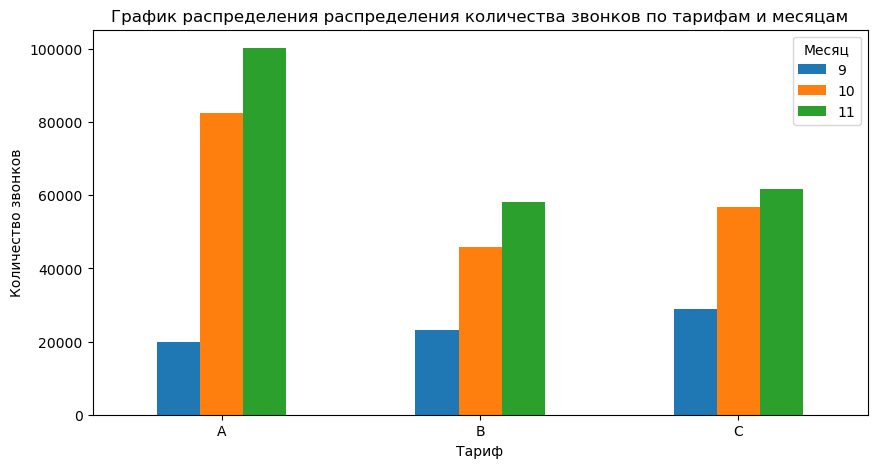

In [72]:
# рассмотри как распределилось количество звонков по тарифам и месяцам
client_rates.pivot_table(index='tariff_plan', columns ='month', values='calls_count', aggfunc='sum')\
             .plot(kind='bar', figsize=(10,5))

plt.title('График распределения распределения количества звонков по тарифам и месяцам')
plt.legend(title='Месяц')
plt.xlabel('Тариф')
plt.ylabel('Количество звонков')
plt.xticks(rotation=360)
plt.show()

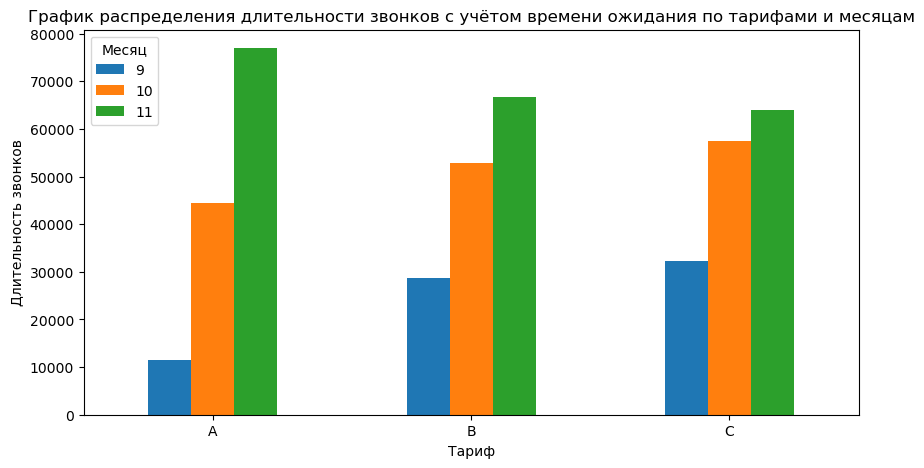

In [73]:
# рассмотрим распределение длительности звонков с учетом времени ожидания по тарифам и месяцам
client_rates.pivot_table(index='tariff_plan', columns ='month', values='total_call_duration', aggfunc='sum')\
             .plot(kind='bar', figsize=(10,5))

plt.title('График распределения длительности звонков с учётом времени ожидания по тарифами и месяцам')
plt.legend(title='Месяц')
plt.xlabel('Тариф')
plt.ylabel('Длительность звонков')
plt.xticks(rotation=360)
plt.show()

*Распределение количества звонков и длительности звонков по тарифам и месяцам схожи.*  
*От сентября к ноябрю количество звонков и длительность звонков увеличивается.*  
*На каждом тарифе меньше всего в сентябре и больше всего в ноябре.*  

In [74]:
# выделим исходящие внешние звонки
out_internal_false = (client_rates['direction']=='out') & (client_rates['internal']==False)

# добавим столбец со стоимостью за исходящие внешние звонки
client_rates.loc[out_internal_false, 'price_out'] = client_rates['total_call_duration'] * client_rates['cost_out_calls_except_internal']

In [75]:
display (client_rates.sample(5))

user_id  month direction  internal tariff_plan  total_call_duration  \
1444   168303     11        in     False           C                  6.0   
849    167402      9        in      True           B                  5.0   
689    167172     11        in     False           B                 19.0   
1465   168361     10       out     False           A               3397.0   
1366   168128     10       out     False           A                 62.0   

      calls_count  cost_month  out_calls_in_tariff  cost_out_calls_over_limit  \
1444            3        1000                    0                       0.30   
849             1        2000                  500                       0.15   
689            21        2000                  500                       0.15   
1465         6056        4000                 2000                       0.10   
1366           90        4000                 2000                       0.10   

      cost_out_calls_except_internal  price_out  
1444                             0.7        NaN  
849                              0.5        NaN  
689                              0.5        NaN  
1465                             0.3     1019.1  
1366                             0.3       18.6

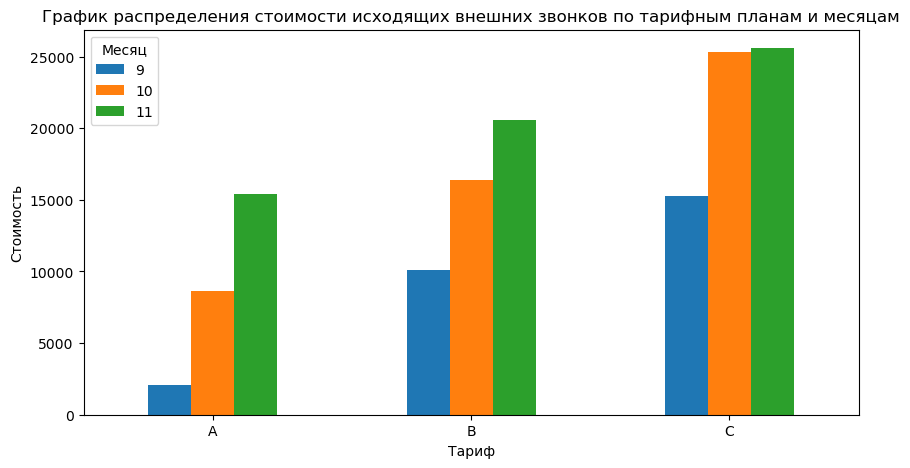

In [76]:
# построим график стоимости исходящих внешних звонков по тарифным планам и месяцам 
client_rates.pivot_table(index='tariff_plan', columns ='month', values='price_out', aggfunc='sum')\
             .plot(kind='bar', figsize=(10,5))

plt.title('График распределения стоимости исходящих внешних звонков по тарифным планам и месяцам')
plt.legend(title='Месяц')
plt.xlabel('Тариф')
plt.ylabel('Стоимость')
plt.xticks(rotation=360)
plt.show()

*На тарифе С за исходящие внешние звонки клиенты платят больше чем на других тарифах.*

In [77]:
# выделим исходящие звонки внутри сети сверх лимита
internal_true_over_limit = ((client_rates['direction']=='out') & \
                            (client_rates['internal']==True) & \
                            (client_rates['total_call_duration'] > client_rates['out_calls_in_tariff']))

# добавим столбец с расходами за звонки внутри сети сверх лимита
client_rates.loc[internal_true_over_limit, 'price_over_limit'] = ((client_rates['total_call_duration'] - client_rates['out_calls_in_tariff']) * \
                                                                   client_rates['cost_out_calls_over_limit'])

In [78]:
display (client_rates.sample(5))

user_id  month direction  internal tariff_plan  total_call_duration  \
321    166803      9       out     False           C                  1.0   
1083   167682      9        in     False           C                  1.0   
446    166971      9       out     False           B                 44.0   
1332   168073     10       out     False           C                  5.0   
1118   167747     11       out     False           C               1013.0   

      calls_count  cost_month  out_calls_in_tariff  cost_out_calls_over_limit  \
321             2        1000                    0                       0.30   
1083            1        1000                    0                       0.30   
446            30        2000                  500                       0.15   
1332            5        1000                    0                       0.30   
1118          436        1000                    0                       0.30   

      cost_out_calls_except_internal  price_out  price_over_limit  
321                              0.7        0.7               NaN  
1083                             0.7        NaN               NaN  
446                              0.5       22.0               NaN  
1332                             0.7        3.5               NaN  
1118                             0.7      709.1               NaN

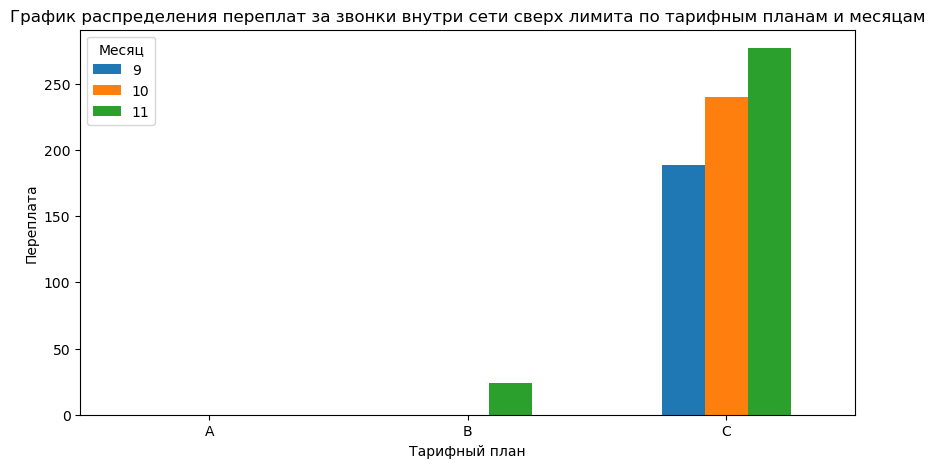

In [79]:
# построим график по переплатам за звонки внутри сети сверх лимита по тарифным планам и месяцам 
client_rates.pivot_table(index='tariff_plan', columns ='month', values='price_over_limit', aggfunc='sum')\
             .plot(kind='bar', figsize=(10,5))

plt.title('График распределения переплат за звонки внутри сети сверх лимита по тарифным планам и месяцам')
plt.legend(title='Месяц')
plt.xlabel('Тарифный план')
plt.ylabel('Переплата')
plt.xticks(rotation=360)
plt.show()

*Переплаты имеются в ноябре у клиентов на тарифе В.*  
*И переплаты есть у клиентов на тарифе С, так как в пакете услуг у них нет бесплатных звонков внутри сети.*  
*У клиентов на тарифе А нет переплат, они не выходят сверх лимита.*

In [80]:
# заменим пропуски новых столбцов на 0 
client_rates[['price_out', 'price_over_limit']] = client_rates[['price_out', 'price_over_limit']].fillna(0)

*Добавим столбец с общей суммой расходов за исходящие внешние звонки и за звонки внутри сети сверх лимита*

In [81]:
client_rates['total_cost_minutes'] = client_rates['price_out'] + client_rates['price_over_limit']

In [82]:
display (client_rates.sample(5))

user_id  month direction  internal tariff_plan  total_call_duration  \
1084   167682     10        in     False           C                  2.0   
1205   167947     10        in     False           B                 11.0   
610    167109      9       out     False           C                529.0   
700    167176      9       out      True           B                271.0   
520    167011      9       out     False           C               2094.0   

      calls_count  cost_month  out_calls_in_tariff  cost_out_calls_over_limit  \
1084            1        1000                    0                       0.30   
1205           18        2000                  500                       0.15   
610           241        1000                    0                       0.30   
700           348        2000                  500                       0.15   
520          1697        1000                    0                       0.30   

      cost_out_calls_except_internal  price_out  price_over_limit  \
1084                             0.7        0.0               0.0   
1205                             0.5        0.0               0.0   
610                              0.7      370.3               0.0   
700                              0.5        0.0               0.0   
520                              0.7     1465.8               0.0   

      total_cost_minutes  
1084                 0.0  
1205                 0.0  
610                370.3  
700                  0.0  
520               1465.8

In [83]:
# выделим в отдельную переменную сумму переплат за минуты по пользователю, месяцу, тарифу и ежемесечной плате
total_cost_minutes = client_rates.groupby(['user_id', 'month', 'tariff_plan', 'cost_month'])\
                            .agg({'total_cost_minutes':'sum', })\
                            .reset_index()
display (total_cost_minutes.head())

user_id  month tariff_plan  cost_month  total_cost_minutes
0   166377      9           B        2000               882.0
1   166377     10           B        2000               827.0
2   166377     11           B        2000               795.0
3   166391      9           C        1000                 0.0
4   166391     10           C        1000                 0.0

*В переменной total_cost_minutes посчитаны расходы сверх тарифа для каждого клиента по месяцам.*  
*Если total_cost_minutes равен 0, то у клиента нет переплат по тарифу за минуты.*

##### Подсчет расходов клиентов на операторов 

In [84]:
# выясним сколько операторов у каждого клиента в месяц
active_operators = telecom_data.groupby(['user_id', 'month', 'tariff_plan']).agg({'operator_id':'nunique'}).reset_index()
                            
display (active_operators.head())

user_id  month tariff_plan  operator_id
0   166377      9           B            5
1   166377     10           B            6
2   166377     11           B            5
3   166391      9           C            2
4   166391     10           C            1

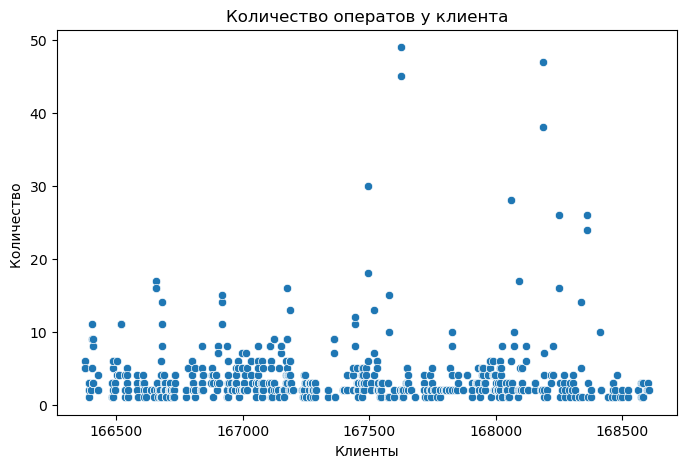

In [85]:
# построим точечный график - количество оператов у клиента в каждый месяц
plt.figure(figsize=(8,5))
sns.scatterplot(data=active_operators, x='user_id', y='operator_id')
plt.title('Количество оператов у клиента')
plt.xlabel('Клиенты')
plt.ylabel('Количество ')
plt.show()

*Чаще всего у клиентов количество операторов меньше 10, но есть клиенты у которых количество операторов больше 10.*  

In [86]:
# добавим к таблице с операторами столбец со стоимостью за каждого оператора
active_operators_merge = active_operators.merge(rates, on='tariff_plan', how='left')\
                                         .drop(columns=['cost_month', 'cost_incoming_calls', \
                                                        'out_calls_in_tariff', 'cost_out_calls_over_limit', \
                                                        'cost_out_calls_except_internal'])

In [87]:
# посчитаем сколько платит клиент за всех операторов в месяц
active_operators_merge['total_cost_operators'] = active_operators_merge['operator_id']*active_operators_merge['cost_operator']
display (active_operators_merge.head())

user_id  month tariff_plan  operator_id  cost_operator  \
0   166377      9           B            5            150   
1   166377     10           B            6            150   
2   166377     11           B            5            150   
3   166391      9           C            2            300   
4   166391     10           C            1            300   

   total_cost_operators  
0                   750  
1                   900  
2                   750  
3                   600  
4                   300

##### Обшие траты клиентов

In [88]:
# объединим две таблицы: с общей стоимостью за израсходованные минуты и стоимостью за всех операторов
cost_minut_oper = total_cost_minutes.merge(active_operators_merge, on=['user_id','month', 'tariff_plan'], how='left')\
                                    .rename(columns = {'operator_id':'count_operators'}) \
                                    .drop(columns=['cost_operator'])

display (cost_minut_oper.head())

user_id  month tariff_plan  cost_month  total_cost_minutes  \
0   166377      9           B        2000               882.0   
1   166377     10           B        2000               827.0   
2   166377     11           B        2000               795.0   
3   166391      9           C        1000                 0.0   
4   166391     10           C        1000                 0.0   

   count_operators  total_cost_operators  
0                5                   750  
1                6                   900  
2                5                   750  
3                2                   600  
4                1                   300

In [89]:
cost_minut_oper['total'] = cost_minut_oper.loc[:, ['cost_month', 'total_cost_minutes', 'total_cost_operators']].sum(axis=1)

In [90]:
display (cost_minut_oper.head())

user_id  month tariff_plan  cost_month  total_cost_minutes  \
0   166377      9           B        2000               882.0   
1   166377     10           B        2000               827.0   
2   166377     11           B        2000               795.0   
3   166391      9           C        1000                 0.0   
4   166391     10           C        1000                 0.0   

   count_operators  total_cost_operators   total  
0                5                   750  3632.0  
1                6                   900  3727.0  
2                5                   750  3545.0  
3                2                   600  1600.0  
4                1                   300  1300.0

In [91]:
print ('Общиие затраты по', cost_minut_oper['user_id'].nunique(), 'уникальным клиентам')

Общиие затраты по 303 уникальным клиентам


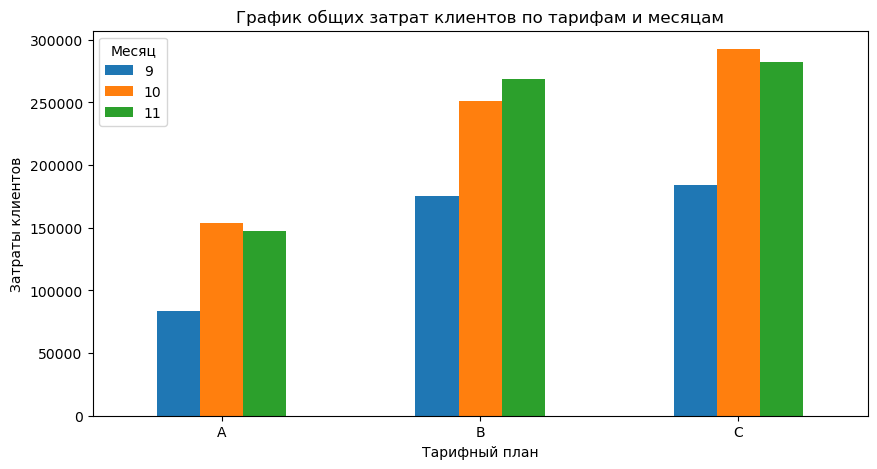

In [92]:
# построим график общих затрат клиентов
cost_minut_oper.pivot_table(index='tariff_plan', columns ='month', values='total', aggfunc='sum')\
             .plot(kind='bar', figsize=(10,5))

plt.title('График общих затрат клиентов по тарифам и месяцам')
plt.legend(title='Месяц')
plt.xlabel('Тарифный план')
plt.ylabel('Затраты клиентов')
plt.xticks(rotation=360)
plt.show()

*График общих затрат клиентов по месяцам и тарифам, так же наглядно показывает текущую прибыль заказчика по месяцам с каждого тарифа.*

#### Вывод по этапу Изучения общих данных 
- Количество активных клиентов: 307;
- При проведении анализа выбросов и аномалий, были выявлены пользователи с нереалистичными данными по звонкам (52 часа за один день, под одним id оператора);
- В момент изучения выбросов и аномалий, было принято решение, что единицами измерения длительности звонков являются секунды;
- Для проведения анализа расходов клиентов выбран период сентябрь - ноябрь;
- Распределение количества звонков и длительности звонков по тарифам и месяцам схожи;  
- От сентября к ноябрю количество звонков и их длительность увеличивается;
- На каждом тарифе меньше всего звонков в сентябре и больше всего в ноябре;  
- Ноябрь был самым активным месяцем по потраченным минутам;
- Активнее всего совершались звонки на тарифе А;
- На тарифе С за исходящие внешние звонки клиенты платят больше чем на других тарифах;
- Переплаты имеются в ноябре у клиентов на тарифе В;  
- И переплаты есть у клиентов на тарифе С, так как в пакете услуг у них нет бесплатных звонков внутри сети;  
- Клиенты, на тарифе А, не выходят сверх лимита;
- Чаще всего у клиентов количество операторов меньше 10, но есть клиенты у которых количество операторов больше 10;
- По графику общих затрат клиентов, больше всего  платят клиенты на тарифе С.


### Определение выручки заказчика и определение оптимальных тарифов

####  Изучение клиентов, которые переплачивают на текущих тарифах

In [93]:
# построим график количества клиентов по тарифам и месяцам
unique_user_tariff = cost_minut_oper.groupby(['tariff_plan', 'month'], as_index=False)\
                                    .agg({'user_id':'nunique'})

fig = px.bar(unique_user_tariff, x='month', y='user_id', color='tariff_plan', text='user_id', barmode = 'group')

fig.update_layout(title = 'График количества клиентов по тарифам и месяцам', 
                  xaxis_title = 'Месяц',
                  yaxis_title = 'Количество клиентов', 
                  legend_title='Тарифный план') 
fig.show()

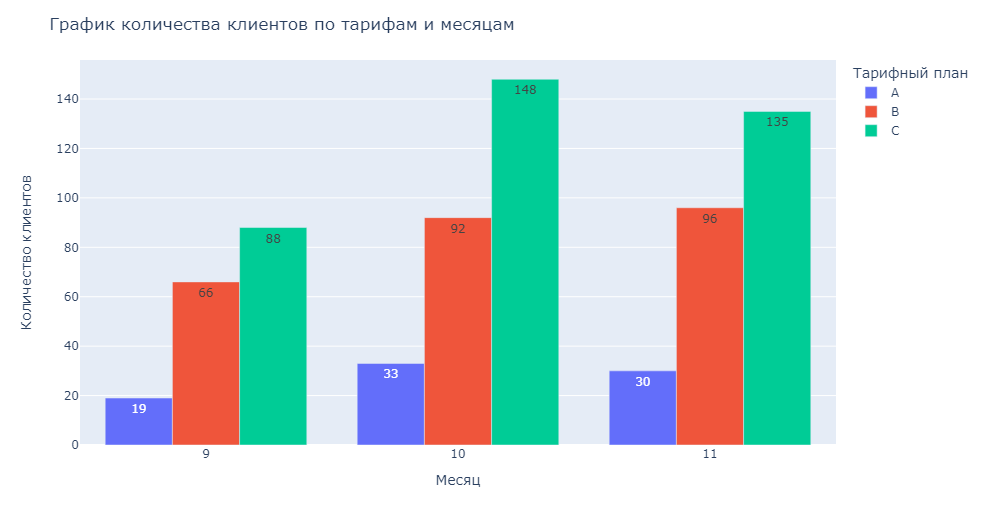

*Наибольшее количество клиентов на тарифе С, который имеет с минимальную стоимотсь в месяц.*

####  Поиск более подходящих тарифов для клиентов, которые переплачивают 

Для дальнейших расчетов вернемся будем использовать client_rates.  
Исключим столбцы cost_out_calls_over_limit, cost_out_calls_except_internal, price_out, price_over_limit, сохраним данные в suitable_plan.

In [94]:
suitable_plan = client_rates.drop(columns=['cost_out_calls_over_limit', 
                                           'cost_out_calls_except_internal', 
                                           'price_out', 
                                           'price_over_limit'])

display (suitable_plan.head(6))

user_id  month direction  internal tariff_plan  total_call_duration  \
0   166377      9        in     False           B                 33.0   
1   166377      9       out     False           B               1764.0   
2   166377      9       out      True           B                  1.0   
3   166377     10        in     False           B                 46.0   
4   166377     10       out     False           B               1654.0   
5   166377     10       out      True           B                  1.0   

   calls_count  cost_month  out_calls_in_tariff  total_cost_minutes  
0           46        2000                  500                 0.0  
1         1393        2000                  500               882.0  
2           13        2000                  500                 0.0  
3           52        2000                  500                 0.0  
4         1347        2000                  500               827.0  
5            7        2000                  500                 0.0

In [95]:
# выведем таблицу с тарифами для удобства
display (rates)

tariff_plan  cost_month  cost_incoming_calls  out_calls_in_tariff  \
0           A        4000                    0                 2000   
1           B        2000                    0                  500   
2           C        1000                    0                    0   

   cost_out_calls_over_limit  cost_out_calls_except_internal  cost_operator  
0                       0.10                             0.3             50  
1                       0.15                             0.5            150  
2                       0.30                             0.7            300

*Далее по каждому из тарифов А, В и С будем добавлять столбец с расчетами, которые будут содержать расходы по исходящим внешним звонкам и по исходящим звонкам внутри сети сверх лимита.*   
*Расчет будет проводиться на основании звонков клиентов и таблицы тарифных планов.*
*Так как расчеты будут добавляться только в определенные строки, строки с пропусками заменим на 0.*

*По тарифу А  добавляем столбец с расчетами - rate_a, который будет содержать расходы по исходящим внешним звонкам и по исходящим звонкам внутри сети сверх лимита.*   

In [96]:
# добавляем столбец rate_a с возможными расходами по тарифу А 
# по исходящим внешним звонкам посчитаем возможные расходы по тарифу А
suitable_plan.loc[(suitable_plan['direction']=='out') & (suitable_plan['internal']==False), 'rate_a'] = \
suitable_plan['total_call_duration']*rates.loc[0,'cost_out_calls_except_internal']

# по исходящим звонки внутри сети сверх лимита почитаем возможные расходы по тарифу А
suitable_plan.loc[((suitable_plan['direction']=='out') & (suitable_plan['internal']==True) & (suitable_plan['total_call_duration'] > rates.loc[0,'out_calls_in_tariff'])), 'rate_a'] = \
((suitable_plan['total_call_duration'] - rates.loc[0,'out_calls_in_tariff']) * rates.loc[0,'cost_out_calls_over_limit'])

# замена пропусков 
suitable_plan['rate_a'] = suitable_plan['rate_a'].fillna(0)

*По тарифу В будем добавлять столбец с расчетами - rate_b, который будет содержать расходы по исходящим внешним звонкам и по исходящим звонкам внутри сети сверх лимита.* 

In [97]:
# добавляем столбец rate_a с возможными расходами по тарифу В 
# по исходящим внешним звонкам посчитаем возможные расходы по тарифу В
suitable_plan.loc[(suitable_plan['direction']=='out') & (suitable_plan['internal']==False), 'rate_b'] = \
suitable_plan['total_call_duration']*rates.loc[1,'cost_out_calls_except_internal']

# по исходящим звонки внутри сети сверх лимита почитаем возможные расходы по тарифу В
suitable_plan.loc[((suitable_plan['direction']=='out') & (suitable_plan['internal']==True) & (suitable_plan['total_call_duration'] > rates.loc[1,'out_calls_in_tariff'])), 'rate_b']=\
((suitable_plan['total_call_duration'] - rates.loc[1,'out_calls_in_tariff']) * rates.loc[1,'cost_out_calls_over_limit'])

# замена пропусков 
suitable_plan['rate_b'] = suitable_plan['rate_b'].fillna(0)


*Далее по тарифу В будем добавлять столбец с расчетами - rate_b, который будет содержать расходы по исходящим внешним звонкам и по исходящим звонкам внутри сети сверх лимита.*

In [98]:
# добавляем столбец rate_a с возможными расходами по тарифу С
# по исходящим внешним звонкам посчитаем возможные расходы по тарифу С
suitable_plan.loc[(suitable_plan['direction']=='out') & (suitable_plan['internal']==False), 'rate_c'] = \
suitable_plan['total_call_duration']*rates.loc[2,'cost_out_calls_except_internal']

# по исходящим звонки внутри сети сверх лимита почитаем возможные расходы по тарифу С
suitable_plan.loc[((suitable_plan['direction']=='out') & (suitable_plan['internal']==True) & (suitable_plan['total_call_duration'] > rates.loc[2,'out_calls_in_tariff'])), 'rate_c']=\
((suitable_plan['total_call_duration'] - rates.loc[2,'out_calls_in_tariff']) * rates.loc[2,'cost_out_calls_over_limit'])

# замена пропусков 
suitable_plan['rate_c'] = suitable_plan['rate_c'].fillna(0)

*Проверим добавление столбцов rate_a, rate_b, rate_c*

In [99]:
suitable_plan.head(2)

user_id  month direction  internal tariff_plan  total_call_duration  \
0   166377      9        in     False           B                 33.0   
1   166377      9       out     False           B               1764.0   

   calls_count  cost_month  out_calls_in_tariff  total_cost_minutes  rate_a  \
0           46        2000                  500                 0.0     0.0   
1         1393        2000                  500               882.0   529.2   

   rate_b  rate_c  
0     0.0     0.0  
1   882.0  1234.8

*Сгруппируем траты клиентов по месяцу, тарифному плану.*

In [100]:
# сгруппируем таблицу по пользователю, месяцу, тарифному плану, плате за месяц. 
# просуммируем данные  по total_call_duration, total_cost_minutes, rate_a , rate_b , rate_c
suitable_plan = suitable_plan.groupby(['user_id',
                                       'month', 
                                       'tariff_plan', 
                                       'cost_month'], as_index=False) \
                              .agg({'total_call_duration':'sum', 
                                    'total_cost_minutes':'sum', 
                                    'rate_a':'sum', 
                                    'rate_b':'sum', 
                                    'rate_c':'sum'})
display (suitable_plan.head())

user_id  month tariff_plan  cost_month  total_call_duration  \
0   166377      9           B        2000               1798.0   
1   166377     10           B        2000               1701.0   
2   166377     11           B        2000               1643.0   
3   166391      9           C        1000                  1.0   
4   166391     10           C        1000                  1.0   

   total_cost_minutes  rate_a  rate_b  rate_c  
0               882.0   529.2   882.0  1235.1  
1               827.0   496.2   827.0  1158.1  
2               795.0   477.0   795.0  1113.9  
3                 0.0     0.0     0.0     0.0  
4                 0.0     0.0     0.0     0.0

*Из таблицы active_operators для каждого пользователя таблицы suitable_plan добавим столбцы с количеством операторов в месяц, их стоимостью по текущему тарифу.*

In [101]:
suitable_plan = suitable_plan.merge(active_operators_merge, on=['user_id','month', 'tariff_plan'], how='left')\
                             .rename(columns = {'operator_id':'count_operators'})

*Добавим столбец cost_current_rate с тратами клиента по текущему тарифу: плата за месяц, плата за минуты, плата за операторов.*

In [102]:
suitable_plan['cost_current_rate'] = suitable_plan['cost_month'] + suitable_plan['total_cost_minutes'] + \
                                     (suitable_plan['count_operators']*suitable_plan['cost_operator'])
display (suitable_plan.head())

user_id  month tariff_plan  cost_month  total_call_duration  \
0   166377      9           B        2000               1798.0   
1   166377     10           B        2000               1701.0   
2   166377     11           B        2000               1643.0   
3   166391      9           C        1000                  1.0   
4   166391     10           C        1000                  1.0   

   total_cost_minutes  rate_a  rate_b  rate_c  count_operators  cost_operator  \
0               882.0   529.2   882.0  1235.1                5            150   
1               827.0   496.2   827.0  1158.1                6            150   
2               795.0   477.0   795.0  1113.9                5            150   
3                 0.0     0.0     0.0     0.0                2            300   
4                 0.0     0.0     0.0     0.0                1            300   

   total_cost_operators  cost_current_rate  
0                   750             3632.0  
1                   900             3727.0  
2                   750             3545.0  
3                   600             1600.0  
4                   300             1300.0

*К каждому из столбцов rate_a, rate_b, rate_с прибавляем соответствующую стоимость тарифа из таблицы rates.*

In [103]:
# к столбцу rate_a прибавляем стоимость тарифа А 
suitable_plan['rate_a'] = suitable_plan['rate_a'] + rates.loc[0,'cost_month'] + (suitable_plan['count_operators'] * rates.loc[0,'cost_operator'])

# к столбцу rate_a прибавляем стоимость тарифа  B
suitable_plan['rate_b'] = suitable_plan['rate_b'] + rates.loc[1,'cost_month'] + (suitable_plan['count_operators'] * rates.loc[1 ,'cost_operator'])

# к столбцу rate_с прибавляем стоимость тарифа C
suitable_plan['rate_c'] = suitable_plan['rate_c'] + rates.loc[2,'cost_month'] + (suitable_plan['count_operators'] * rates.loc[2 ,'cost_operator'])

suitable_plan.head(2)

user_id  month tariff_plan  cost_month  total_call_duration  \
0   166377      9           B        2000               1798.0   
1   166377     10           B        2000               1701.0   

   total_cost_minutes  rate_a  rate_b  rate_c  count_operators  cost_operator  \
0               882.0  4779.2  3632.0  3735.1                5            150   
1               827.0  4796.2  3727.0  3958.1                6            150   

   total_cost_operators  cost_current_rate  
0                   750             3632.0  
1                   900             3727.0

*Для дальнейшей работы выделяем только интересующие нас столбцы с id клиента, месяцем, текущим тарифным планом, текущей платой за тариф и столбцы с ценами по другим тарифным планам.*

In [104]:
tariff_plan = suitable_plan[['user_id', 
                             'month', 
                             'tariff_plan', 
                             'cost_current_rate' , 
                             'rate_a', 'rate_b', 
                             'rate_c']].rename(columns = {'rate_a':'A', 'rate_b':'B', 'rate_c':'C'})
display (tariff_plan.head(2))

user_id  month tariff_plan  cost_current_rate       A       B       C
0   166377      9           B             3632.0  4779.2  3632.0  3735.1
1   166377     10           B             3727.0  4796.2  3727.0  3958.1

*Посчитаем медианные значения стоимости тарифов.*

In [105]:
tariff_plan_median = tariff_plan.groupby(['user_id','tariff_plan'], as_index=False) \
                                .agg({'cost_current_rate':'median', 
                                      'A':'median', 
                                      'B':'median', 
                                      'C':'median'})
display (tariff_plan_median.head(2))

user_id tariff_plan  cost_current_rate       A       B       C
0   166377           B             3632.0  4779.2  3632.0  3735.1
1   166391           C             1600.0  4100.0  2300.0  1600.0

*Найдем минимальную стоимость одного из оптимальных тарифов А,В,С и добавим ее в новый столбец new_current.*
*Так же создадим столбец с наименованием тарифа с минимальной стоимостью.*

In [106]:
# создадим столбец new_current, в который запишем минимальную стоимость из трех столбцов
tariff_plan_median['new_current'] = tariff_plan_median.loc[:, ['A', 'B', 'C']].min(axis=1)

# создадим столбец optimal_tariff, в который запишем название столбца с минимальной стоимостью, то есть наиболее подходищий тариф
tariff_plan_median['optimal_tariff']= tariff_plan_median.loc[:, ['A', 'B', 'C']].idxmin(axis=1)

*Оставим только столбы с id клиента, текущим тарифом и расходами по нему, и оптимальным тарифом и его стоимостью*

In [107]:
# выделим необходимые столбцы
optimal_tarif = tariff_plan_median[['user_id','tariff_plan', 'cost_current_rate' , 'optimal_tariff', 'new_current']]

*__Выделяем клиентов, которым можно предложить более оптимальный тарифный план__*

In [108]:
# выделим пользователей с более оптимальным тарифным планом
tarif = optimal_tarif.query("not (tariff_plan == optimal_tariff)")
print ('Предложить более оптимальный план можно:', tarif['user_id'].nunique(), 'клиентам') 

Предложить более оптимальный план можно: 136 клиентам


In [109]:
display ('В таблице представлен список пользователей с текущим тарифом и предложение более оптимального тарифа', \
         tarif[['user_id', 'tariff_plan', 'optimal_tariff']])

'В таблице представлен список пользователей с текущим тарифом и предложение более оптимального тарифа'

user_id tariff_plan optimal_tariff
5     166406           B              C
6     166407           A              B
7     166428           B              C
8     166481           A              C
12    166495           B              C
..       ...         ...            ...
294   168562           B              C
296   168578           B              C
297   168579           B              C
298   168583           B              C
301   168603           B              C

[136 rows x 3 columns]

####  Изучение выручки заказчика на текущий момент 

In [110]:
# медианная прибыль от переплачивающих клиентов в месяц по текущим тарифным планам
sort_1 = tarif.groupby('tariff_plan', as_index=False).agg({'cost_current_rate':'sum'}).rename(columns = {'cost_current_rate':'current_profit'})
display ('Медианная прибыль от переплачивающих клиентов в месяц по текущим тарифным планам', sort_1)
print( )
# медианная прибыль от переплачивающих клиентов по более оптимальным тарифам в месяц
sort_2 = tarif.groupby('optimal_tariff', as_index=False).agg({'new_current':'sum'})
display ('Медианная прибыль от переплачивающих клиентов по более оптимальным тарифам в месяц', sort_2)

'Медианная прибыль от переплачивающих клиентов в месяц по текущим тарифным планам'

tariff_plan  current_profit
0           A       118942.35
1           B       249344.35
2           C        50888.45

'Медианная прибыль от переплачивающих клиентов по более оптимальным тарифам в месяц'

optimal_tariff  new_current
0              A     12341.30
1              B     63016.50
2              C    224365.35

In [111]:
# переменная sort с медианной прибылью по текущим тарифам и по оптимальным тарифам
sort = sort_1.merge(sort_2, left_index=True, right_index=True)
display(sort)

tariff_plan  current_profit optimal_tariff  new_current
0           A       118942.35              A     12341.30
1           B       249344.35              B     63016.50
2           C        50888.45              C    224365.35

In [112]:
# построим график, на котором сравним медианную прибыль в месяц по текущим тарифам с возможной прибылью по оптимальным тарифам
fig = px.bar(sort, x='tariff_plan', y=['current_profit', 'new_current']) 

fig.update_layout(title = 'Медианная прибыль в месяц по текущим и оптимальным тарифам', 
                  xaxis_title = 'Тарифный план',
                  yaxis_title = 'Прибыль', 
                  legend_title='Прибыль') 
fig.update_layout(barmode='group')
fig.show()

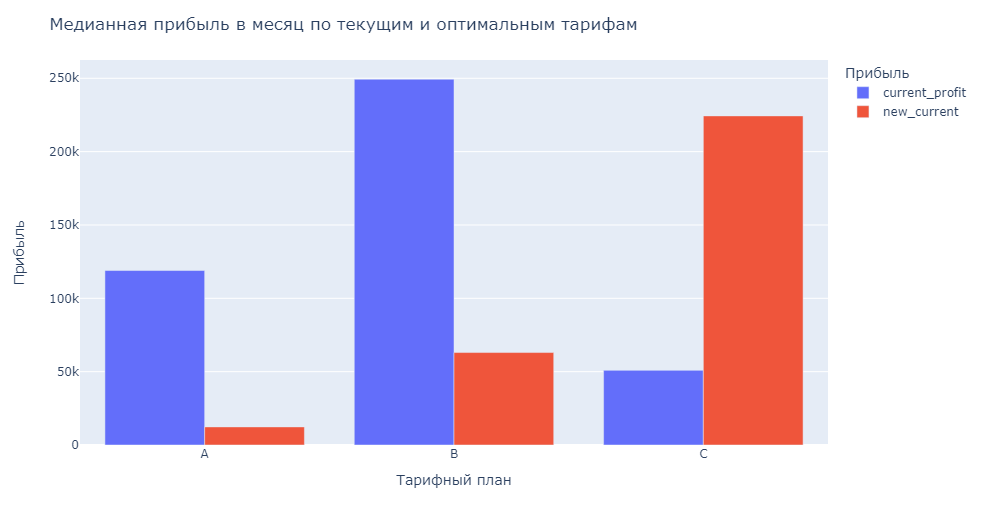

*После приведения клиентов к оптимальному тарифу, наблюдаются изменения:*  
*- по тарифам А и В прибыль уменьшится;*  
*- по тарифу С прибыль значительно увеличится.*

In [113]:
# сумма выручки по текущим тарифам
sum_old_rate = sort['current_profit'].sum() 

# сумма выручки по оптимальным тарифам
sum_new_rate = sort['new_current'].sum()

In [114]:
# построим график, на котором сравним изменения выручки
fig = px.bar(x=['current_profit', 'new_current'], y=[sum_old_rate, sum_new_rate], text=[sum_old_rate, sum_new_rate],
              color=['current_profit', 'new_current']) 

fig.update_layout(title = 'Сравнение выручки по текущим и оптимальным тарифам', 
                  xaxis_title = 'Сумма выручки по текущим тарифам / по оптимальным тарифам',
                  yaxis_title = 'Выручка', 
                  legend_title='Прибыль') 
fig.update_traces(showlegend=True)
fig.show()

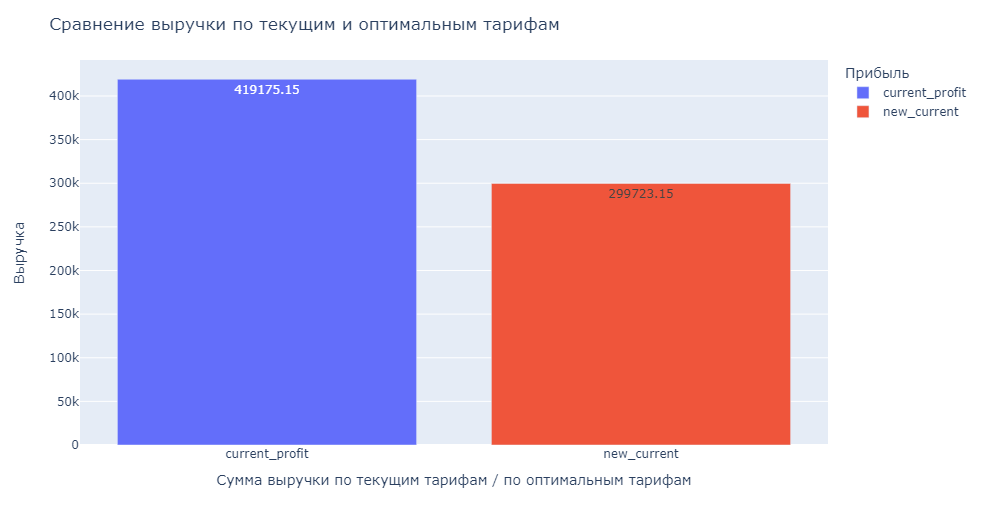

In [115]:
print ('Выгода клиентов/потери заказчика составят:', round(sum_old_rate - sum_new_rate, 2), 'рублей' )

Выгода клиентов/потери заказчика составят: 119452.0 рублей


*После предложения оптимальных тарифов сумма выручки заказчика в месяц уменьшится.*

#### Выводы по этапу Определения выручки заказчика и определению оптимальных тарифов:
- Наибольшее количество клиентов находятся на тарифе С, который имеет минимальную стоимость в месяц;  
- Предложить более оптимальный план можно: 104 клиентам;  
- После приведения клиентов к оптимальному тарифу, наблюдаются изменения:по тарифам А и В прибыль уменьшится, по тарифу С прибыль увеличится;   
- После предложения оптимальных тарифов сумма выручки заказчика в месяц уменьшится.

## Проверка статистических гипотез

Для проверки статистических гипотез будем использовать t-критерий Стьюдента, так как в обоих случаях выборки независимы между собой.  

Определим пороговое значение **alpha = 0.05** 

**Первая гипотеза**

**Нулевая гипотеза:** Среднее количество звонков в месяц у клиента на тарифе А  и у клиента на тарифе В равны    
**Альтернативная гипотеза:** Среднее количество звонков в месяц у клиента на тарифе А  и у клиента на тарифе В различаются

In [116]:
telecom_data.head(2)

user_id       date direction internal  operator_id  is_missed_call  \
107   166377 2019-09-02        in    False       880028           False   
108   166377 2019-09-02        in    False       880026           False   

     calls_count  call_duration  total_call_duration  month tariff_plan  \
107            2             66                   75      9           B   
108            1             31                   34      9           B   

    date_start  
107 2019-08-01  
108 2019-08-01

*Выделяем тафифный план и считаем количество звонков по пользователям и месяцам.*

In [117]:
data_1 = telecom_data[telecom_data['tariff_plan'] == 'A'].groupby(['user_id', 'month'], as_index=False)\
                                                         .agg({'calls_count':'sum'})
user_a = data_1['calls_count']

In [118]:
data_2 = telecom_data[telecom_data['tariff_plan'] == 'B'].groupby(['user_id', 'month'], as_index=False)\
                                                         .agg({'calls_count':'sum'})
user_b = data_2['calls_count']

In [119]:
# проверим гипотезу
results = st.ttest_ind (user_a, user_b, equal_var = False)

alpha = 0.05

print (results.pvalue) 

if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

0.017979117029901518
Отвергаем нулевую гипотезу


*Нулевая гипотеза отвергнута, среднее количество звонков в месяц у клиента на тарифе А  и у клиента на тарифе В различаются*

**Вторая гипотеза**

**Нулевая гипотеза:**  Среднее количество пропущенных звонков в месяц у клиента на тарифе А  и у клиента на тарифе С равны  
**Альтернативная гипотеза:** Среднее количество пропущенных звонков в месяц у клиента на тарифе А  и у клиента на тарифе С различаются

*Выделяем пропущенные звонки и тафифный план, считаем количество пропущенных звонков по пользователям и месяцам.*

In [120]:
data_a = telecom_data[(telecom_data['call_duration'] == 0) & (telecom_data['tariff_plan'] == 'A')].groupby(['user_id', 'month'], as_index=False)\
                                                                                                  .agg({'calls_count':'sum'})
user_1 = data_a['calls_count']

In [121]:
data_c = telecom_data[(telecom_data['call_duration'] == 0) & (telecom_data['tariff_plan'] == 'C')].groupby(['user_id', 'month'], as_index=False)\
                                                                                                  .agg({'calls_count':'sum'})
user_2 = data_c['calls_count']

In [122]:
# проверим гипотезу
alpha = 0.05

results = st.ttest_ind(user_1, user_2, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.026857155240891998
Отвергаем нулевую гипотезу


*Нулевая гипотеза отвергнута, среднее количество пропущенных звонков в месяц у клиента на тарифе А и у клиента на тарифе С различаются.*

## Общие выводы, рекомендации для заказчика

**При предобработке данных было выполнено:**
- Обнаружение пропусков в датасете telecom, в столбцах operator_id и internal. Пропуски заменены заглушками;
- В датасете telecom удалено 4900 явных дубликатов;
- Изменены типы данных столбцов date, operator_id и date_start;
- Добавлен столбец с номером месяца.


**При проведении исследовательского анализа было определено:**
- Количество активных клиентов - 307;
- При проведении анализа выбросов и аномалий, были выявлены пользователи с нереалистичными данными по звонкам (52 часа за один день, под одному id оператора);
- В момент изучения выбросов и аномалий, было принято решение, что единицами измерения длительности звонков являются секунды;
- Для проведения анализа расходов клиентов выбран период сентябрь - ноябрь;
- Распределение количества звонков и длительности звонков по тарифам и месяцам схожи;
- От сентября к ноябрю количество звонков и их длительность увеличивается;
- На каждом тарифе меньше всего звонков в сентябре и больше всего в ноябре;
-  Ноябрь был самым активным месяцем по потраченным минутам;
- Активнее всего совершались звонки на тарифе А;
- На тарифе С за исходящие внешние звонки клиенты платят больше, чем на других тарифах;
- Переплаты имеются в ноябре у клиентов на тарифе В, а так же у клиентов на тарифе С, так как в пакете услуг на тарифе С нет бесплатных звонков внутри сети;
- Клиенты, на тарифе А, не выходят сверх лимита;
- Чаще всего у клиентов количество операторов меньше 10, но есть клиенты, у которых количество операторов достигает 50;
- По графику общих затрат клиентов, больше всего платят клиенты на тарифе С.
-  Наибольшее количество клиентов находятся на тарифе С, который имеет с минимальную стоимость в месяц;    
- Предложить более оптимальный план можно: 104 клиентам;  
- После предложения оптимальных тарифов сумма выручки заказчика в месяц уменьшится.


**При проверке статистических гипотез выявлено:**
- Среднее количество звонков в месяц у клиента на тарифе А и у клиента на тарифе В различаются;
- Среднее количество пропущенных звонков в месяц у клиента на тарифе А и у клиента на тарифе С различаются.

**Рекомендации заказчику:**
-  Провести работы с клиентами, которые по одному номеру id оператора выполняют больше 12 часов работ в день. Возможно, под одним id оператора, работают больше сотрудников, если это подтвердиться, то стоит изменить систему контроля, внести штрафы или блокировки.Так же изучить клиентов, у которых количество операторов 0, но звонки совершаются.

- В целях компенсации изменившейся выручки с перевода клиентов на более оптимальные тарифы, стоит запустить рекламные акции по привлечению новых клиентов.